In [75]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150
from scipy.io import savemat
from tenpy.tools.params import get_parameter
from matplotlib import colors
import matplotlib.pyplot as plt

In [76]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
tenpy.tools.misc.setup_logging(to_stdout="INFO")
import pickle

In [77]:
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.algorithms import dmrg
from tenpy.networks.site import SpinSite, SpinHalfSite, SpinHalfFermionSite
from tenpy.models.lattice import Triangular, Square
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel

In [78]:
''' Fermi-Hubbard model '''

class Hubbard_mixed(CouplingModel, MPOModel):
    def __init__(self, model_param):
        
        ''' system size '''
        Lx = model_param["Lx"]
        Ly = model_param["Ly"]
        q = model_param["fraction"]
#         Lx = q 
        
        ''' coupling constants'''
        t = model_param["t"]
        U = model_param["U"]
#         phi = model_param["phase"]
        
        
        ''' boundary conditions'''
        bc_MPS = model_param["bc_MPS"]
        bc_y = model_param["bc_y"]
        bc_x = model_param["bc_x"]
        
        
        ''' site with particle + U(1) symmetry conservation'''
        site = SpinHalfFermionSite(cons_N = 'N', cons_Sz = 'Sz')
        
        ''' define square lattice'''
        lat = Square(Lx, Ly, site, bc=[bc_x, bc_y], bc_MPS=bc_MPS)   
        

        CouplingModel.__init__(self, lat)
        
        
        for i in range(Lx):
            for j in range(Ly):
                '''hopping along x-direction + diagonal'''
                self.add_coupling_term((-t) * 1j + (-t) *  (-1)**(i+1) * np.exp(1j * 2 * np.pi/Ly * j), i * Ly + j, (i+1) * Ly + j, 'Cdu', 'Cu', plus_hc=True)
                self.add_coupling_term((-t) * 1j + (-t) *  (-1)**(i+1) * np.exp(1j * 2 * np.pi/Ly * j), i * Ly + j, (i+1) * Ly + j, 'Cdd', 'Cd', plus_hc=True)
                
                ''' hopping along y-direction'''                           
                self.add_onsite_term( (-t) * ((-1)**i) * 2 * np.cos(2*np.pi/Ly * j), i * Ly + j, 'Nu')
                self.add_onsite_term( (-t) * ((-1)**i) * 2 * np.cos(2*np.pi/Ly * j), i * Ly + j, 'Nd')
                
        ''' on-site interactions'''         
        for i in range(Lx):
            for j in range(Ly//2 + 1): 
#                 print(i * Ly + j, i * Ly + Ly - 1 - j)
                if j != Ly - 1 - j:
                    self.add_coupling_term( U, i * Ly + j, i * Ly + Ly - 1 - j, 'Nu', 'Nd')
                else:
                    self.add_onsite_term(U, i * Ly + j, 'NuNd')
                
            
        MPOModel.__init__(self, lat, self.calc_H_MPO())
        ax = plt.gca()
        lat.plot_basis(ax)

In [79]:
model_param = {"Lattice" : Square,
              "Ly" : 3,
              "Lx" : 2,
              "t" : 1.0,
              "U" : 0.0,
              "fraction" : 2,
              "bc_MPS" : "infinite",
              "bc_y" : 'periodic',
              "bc_x" : 'periodic'}

dmrg_params = {"trunc_params": {"chi_max": 300, "svd_min": 1.e-10}, "mixer": True, "max_sweeps": 500}

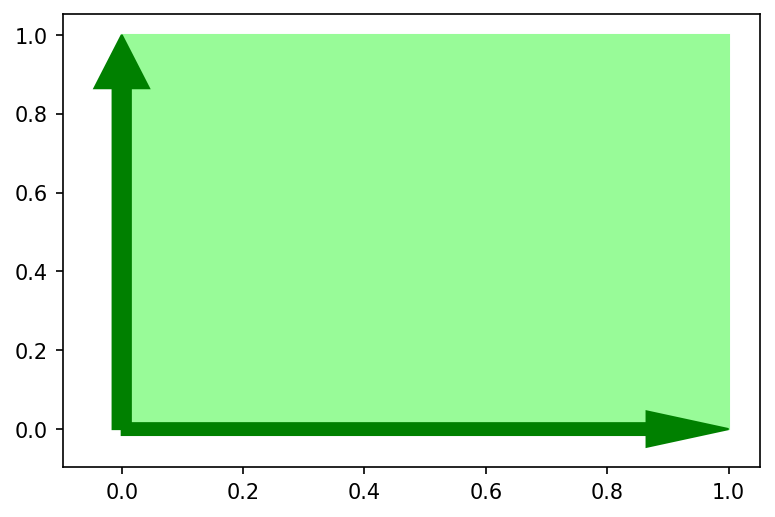

In [80]:
M = Hubbard_mixed(model_param)
sites = M.lat.mps_sites()
psi = MPS.from_product_state(sites,["up","down","down","up","up","down"],"infinite")

In [81]:
# print(M.all_coupling_terms().to_TermList())
# print(M.all_onsite_terms().to_TermList())


In [82]:
info = dmrg.run(psi, M, dmrg_params)
energy = info['E']
delta_energy = abs(info["sweep_statistics"]['E'][-1] - info["sweep_statistics"]['E'][-2])

INFO    : DMRG: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : start environment_sweep
INFO    : trunc_params: reading 'chi_max'=300
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : DMRG: reading 'max_sweeps'=500
INFO    : DMRG: reading 'mixer'=True
INFO    : activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO    : Running sweep with optimization
INFO    : start environment_sweep
INFO    : checkpoint after sweep 10
energy=-2.3642891225664471, max S=2.7198645757435331, age=198, norm_err=4.5e-10
Current memory usage 699240.0MB, wall time: 805.0s
Delta E = nan, Delta S = 1.5906e-01 (per sweep)
max trunc_err = 1.4993e-07, max E_trunc = 1.5393e-06
chi: [300, 300, 300, 300, 300, 300]
INFO    : Running sweep with optimization
INFO    : disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO    : start environment_sweep
INFO    : checkpoint after sweep 20
energy=-2.3642898203123743, max S=2.7198642480793938, age=378, norm_err=1.2e-13
Current me